# Machine Learning Analysis for Climate Data

Simple ML models for CO2 emission prediction and analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
co2_data = pd.read_csv('data/co2_pcap_cons.csv')
energy_data = pd.read_excel('data/API_EG.USE.PCAP.KG.OE_DS2_en_excel_v2_20374.xls', skiprows=3)
gdp_data = pd.read_excel('data/API_NY.GDP.PCAP.KD.ZG_DS2_en_excel_v2_122434.xls', skiprows=3)
us_energy_data = pd.read_excel('data/us_energy.xls', skiprows=3)
us_co2_data = pd.read_excel('invidual/yearly_co2_emissions_1000_tonnes.xlsx')
us_temp_data = pd.read_csv('invidual/temperature.csv', encoding='latin-1')
us_disasters_data = pd.read_csv('invidual/disasters.csv', encoding='latin-1', on_bad_lines='skip')
us_energy_per_person = pd.read_excel('invidual/energy_use_per_person.xlsx')
us_gdp_growth = pd.read_excel('invidual/gdp_per_capita_yearly_growth.xlsx')

In [3]:
def clean_co2_data(df):
    df_clean = df.copy()
    
    if 'country' not in df_clean.columns:
        if df_clean.index.name == 'country':
            df_clean = df_clean.reset_index()
        elif 'Country' in df_clean.columns:
            df_clean = df_clean.rename(columns={'Country': 'country'})
        else:
            df_clean.columns = ['country'] + list(df_clean.columns[1:])
    
    year_columns = [col for col in df_clean.columns if col != 'country' and str(col).isdigit()]
    
    df_clean = df_clean.melt(id_vars=['country'], value_vars=year_columns, 
                           var_name='Year', value_name='CO2_per_capita')
    
    df_clean['Year'] = pd.to_numeric(df_clean['Year'])
    df_clean['CO2_per_capita'] = pd.to_numeric(df_clean['CO2_per_capita'], errors='coerce')
    
    df_clean = df_clean.rename(columns={'country': 'Country'})
    
    return df_clean.dropna()

def clean_worldbank_data(df, value_name):
    df_clean = df.copy()
    
    cols_to_drop = ['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 67']
    for col in cols_to_drop:
        if col in df_clean.columns:
            df_clean = df_clean.drop(col, axis=1)
    
    df_clean = df_clean.melt(id_vars=['Country Name'], var_name='Year', value_name=value_name)
    
    df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')
    df_clean[value_name] = pd.to_numeric(df_clean[value_name], errors='coerce')
    df_clean = df_clean.rename(columns={'Country Name': 'Country'})
    
    return df_clean.dropna()

def clean_us_co2_data(df):
    df_clean = df.copy()
    
    if df_clean.index.name == 'country' or 'country' not in df_clean.columns:
        df_clean = df_clean.reset_index()
        if df_clean.columns[0] == 'index':
            df_clean = df_clean.rename(columns={'index': 'country'})
    
    df_clean = pd.melt(df_clean, id_vars=['country'], var_name='Year', value_name='CO2_emissions_1000_tonnes')
    df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce')
    df_clean = df_clean.dropna(subset=['Year', 'CO2_emissions_1000_tonnes'])
    df_clean = df_clean[df_clean['Year'] >= 1960]
    df_clean = df_clean.rename(columns={'country': 'Country'})
    
    return df_clean

In [4]:
co2_clean = clean_co2_data(co2_data)
energy_clean = clean_worldbank_data(energy_data, 'Energy_use_per_capita')
gdp_clean = clean_worldbank_data(gdp_data, 'GDP_growth')
us_energy_clean = clean_worldbank_data(us_energy_data, 'US_Energy_use_per_capita')
us_co2_clean = clean_us_co2_data(us_co2_data)

norway_co2 = co2_clean[co2_clean['Country'].str.contains('Norway', case=False, na=False)]
us_co2_per_capita = co2_clean[co2_clean['Country'].str.contains('United States', case=False, na=False)]
norway_energy = energy_clean[energy_clean['Country'].str.contains('Norway', case=False, na=False)]
us_energy_per_capita_global = energy_clean[energy_clean['Country'].str.contains('United States', case=False, na=False)]
norway_gdp = gdp_clean[gdp_clean['Country'].str.contains('Norway', case=False, na=False)]
us_gdp_global = gdp_clean[gdp_clean['Country'].str.contains('United States', case=False, na=False)]
us_energy_filtered = us_energy_clean[us_energy_clean['Country'].str.contains('United States', case=False, na=False)]

## 1. Simple Linear Regression: CO2 Emission Prediction

In [5]:
norway_yearly = norway_co2.groupby('Year')['CO2_per_capita'].mean().reset_index()
norway_yearly = norway_yearly.sort_values('Year')

X = norway_yearly['Year'].values.reshape(-1, 1)
y = norway_yearly['CO2_per_capita'].values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

print(f"Model Performance:")
print(f"R² Score: {r2_score(y, y_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y, y_pred):.3f}")
print(f"Slope: {model.coef_[0]:.4f} (tons per year)")
print(f"Intercept: {model.intercept_:.2f}")

Model Performance:
R² Score: 0.831
Mean Squared Error: 2.026
Slope: 0.0491 (tons per year)
Intercept: -90.63


Future Predictions:
2025: 8.76 metric tons per capita
2030: 9.01 metric tons per capita
2035: 9.25 metric tons per capita


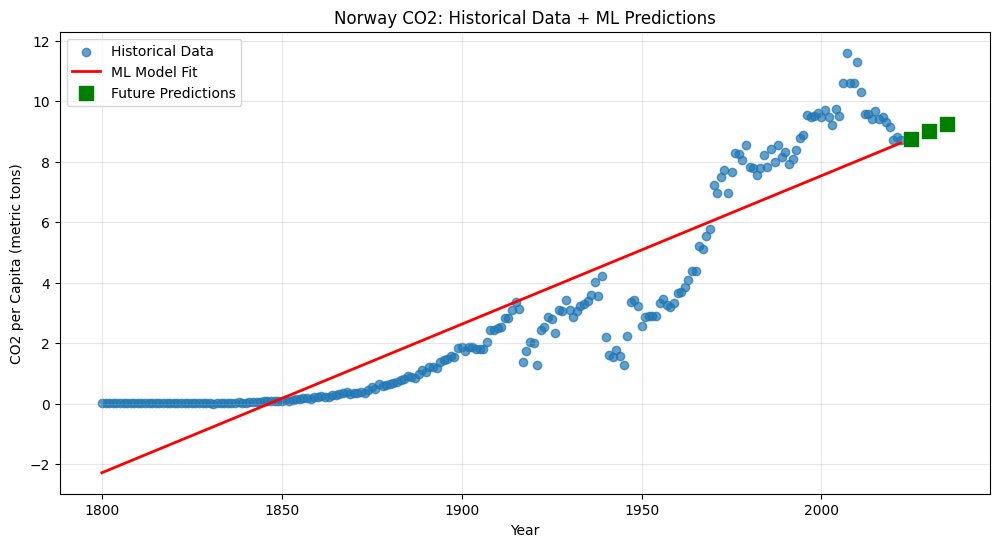

In [6]:
future_years = np.array([2025, 2030, 2035]).reshape(-1, 1)
future_predictions = model.predict(future_years)

print(f"Future Predictions:")
for year, pred in zip([2025, 2030, 2035], future_predictions):
    print(f"{year}: {pred:.2f} metric tons per capita")

plt.figure(figsize=(12, 6))
plt.scatter(norway_yearly['Year'], norway_yearly['CO2_per_capita'], alpha=0.7, label='Historical Data')
plt.plot(norway_yearly['Year'], y_pred, color='red', linewidth=2, label='ML Model Fit')
plt.scatter(future_years, future_predictions, color='green', s=100, marker='s', label='Future Predictions')
plt.xlabel('Year')
plt.ylabel('CO2 per Capita (metric tons)')
plt.title('Norway CO2: Historical Data + ML Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 2. Multi-Variable Regression: Energy + GDP vs CO2

In [7]:
norway_merged = norway_energy.merge(norway_co2, on=['Country', 'Year'], how='inner')
norway_merged = norway_merged.merge(norway_gdp, on=['Country', 'Year'], how='inner')
norway_merged = norway_merged.dropna()

if not norway_merged.empty:
    X_multi = norway_merged[['Energy_use_per_capita', 'GDP_growth']].values
    y_multi = norway_merged['CO2_per_capita'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model_multi = LinearRegression()
    model_multi.fit(X_train_scaled, y_train)
    
    y_pred_train = model_multi.predict(X_train_scaled)
    y_pred_test = model_multi.predict(X_test_scaled)
    
    print(f"Multi-Variable Model Performance:")
    print(f"Training R²: {r2_score(y_train, y_pred_train):.3f}")
    print(f"Test R²: {r2_score(y_test, y_pred_test):.3f}")
    print(f"Feature Coefficients:")
    print(f"Energy Use: {model_multi.coef_[0]:.4f}")
    print(f"GDP Growth: {model_multi.coef_[1]:.4f}")
    print(f"Intercept: {model_multi.intercept_:.2f}")

Multi-Variable Model Performance:
Training R²: 0.889
Test R²: 0.877
Feature Coefficients:
Energy Use: 1.6772
GDP Growth: 0.1131
Intercept: 8.32


## 3. US CO2 Prediction Model

In [8]:
us_co2_by_year = us_co2_clean.groupby('Year')['CO2_emissions_1000_tonnes'].sum().reset_index()
us_co2_by_year = us_co2_by_year.sort_values('Year')

X_us = us_co2_by_year['Year'].values.reshape(-1, 1)
y_us = us_co2_by_year['CO2_emissions_1000_tonnes'].values

model_us = LinearRegression()
model_us.fit(X_us, y_us)

y_pred_us = model_us.predict(X_us)

print(f"US Model Performance:")
print(f"R² Score: {r2_score(y_us, y_pred_us):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_us, y_pred_us):.0f}")
print(f"Slope: {model_us.coef_[0]:.2f} (1000 tonnes per year)")

future_predictions_us = model_us.predict(future_years)
print(f"\nUS Future Predictions:")
for year, pred in zip([2025, 2030, 2035], future_predictions_us):
    print(f"{year}: {pred:.0f} thousand tonnes")

US Model Performance:
R² Score: 0.960
Mean Squared Error: 1799250847187
Slope: 413532.26 (1000 tonnes per year)

US Future Predictions:
2025: 36140027 thousand tonnes
2030: 38207688 thousand tonnes
2035: 40275350 thousand tonnes


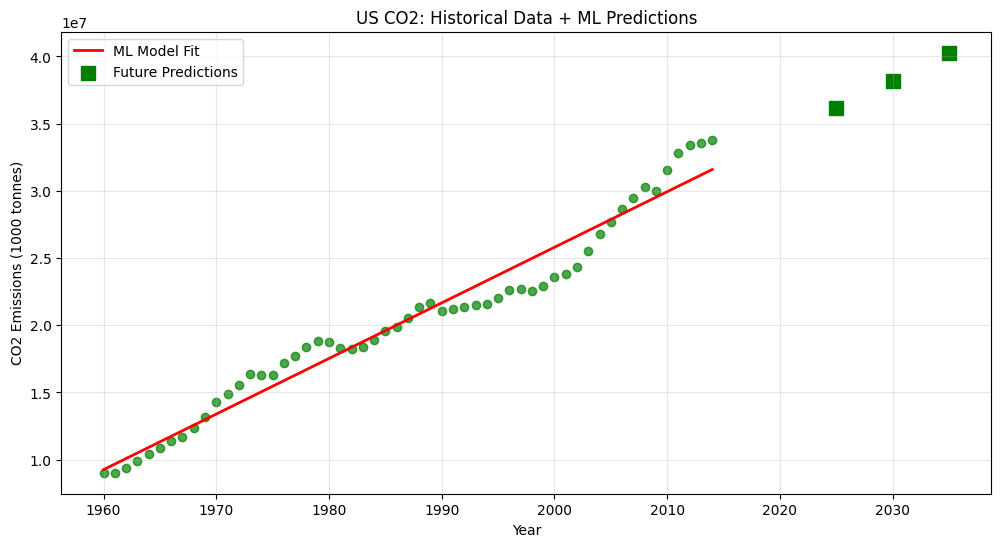

In [9]:
plt.figure(figsize=(12, 6))
plt.scatter(us_co2_by_year['Year'], us_co2_by_year['CO2_emissions_1000_tonnes'], alpha=0.7, color='green')
plt.plot(us_co2_by_year['Year'], y_pred_us, color='red', linewidth=2, label='ML Model Fit')
plt.scatter(future_years, future_predictions_us, color='green', s=100, marker='s', label='Future Predictions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (1000 tonnes)')
plt.title('US CO2: Historical Data + ML Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Model Comparison: Norway vs US

In [10]:
comparison_data = {
    'Country': ['Norway', 'United States'],
    'R² Score': [r2_score(y, y_pred), r2_score(y_us, y_pred_us)],
    'MSE': [mean_squared_error(y, y_pred), mean_squared_error(y_us, y_pred_us)],
    'Slope': [model.coef_[0], model_us.coef_[0]],
    'Data Points': [len(norway_yearly), len(us_co2_by_year)]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(comparison_df.to_string(index=False))

Model Comparison:
      Country  R² Score          MSE         Slope  Data Points
       Norway  0.831328 2.025626e+00      0.049083          223
United States  0.959922 1.799251e+12 413532.259259           55


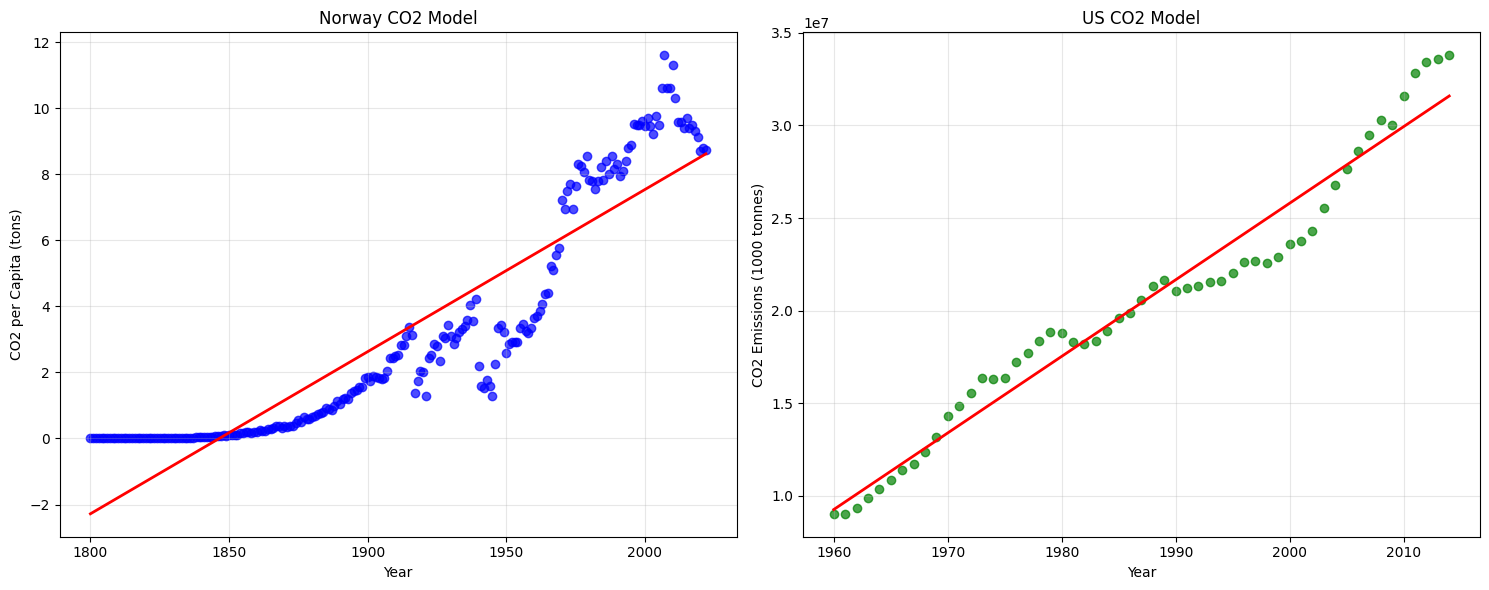

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(norway_yearly['Year'], norway_yearly['CO2_per_capita'], alpha=0.7, color='blue')
ax1.plot(norway_yearly['Year'], y_pred, color='red', linewidth=2)
ax1.set_title('Norway CO2 Model')
ax1.set_xlabel('Year')
ax1.set_ylabel('CO2 per Capita (tons)')
ax1.grid(True, alpha=0.3)

ax2.scatter(us_co2_by_year['Year'], us_co2_by_year['CO2_emissions_1000_tonnes'], alpha=0.7, color='green')
ax2.plot(us_co2_by_year['Year'], y_pred_us, color='red', linewidth=2)
ax2.set_title('US CO2 Model')
ax2.set_xlabel('Year')
ax2.set_ylabel('CO2 Emissions (1000 tonnes)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Random Forrest Regression

## Random Forest Regression: Multi-Feature Prediction
Random Forest Performance:
Training R²: 0.984
Test R²: 0.955
Training MAE: 0.157
Test MAE: 0.357

Feature Importance:
   Feature  Importance
      Year    0.511291
Energy Use    0.469495
GDP Growth    0.019214


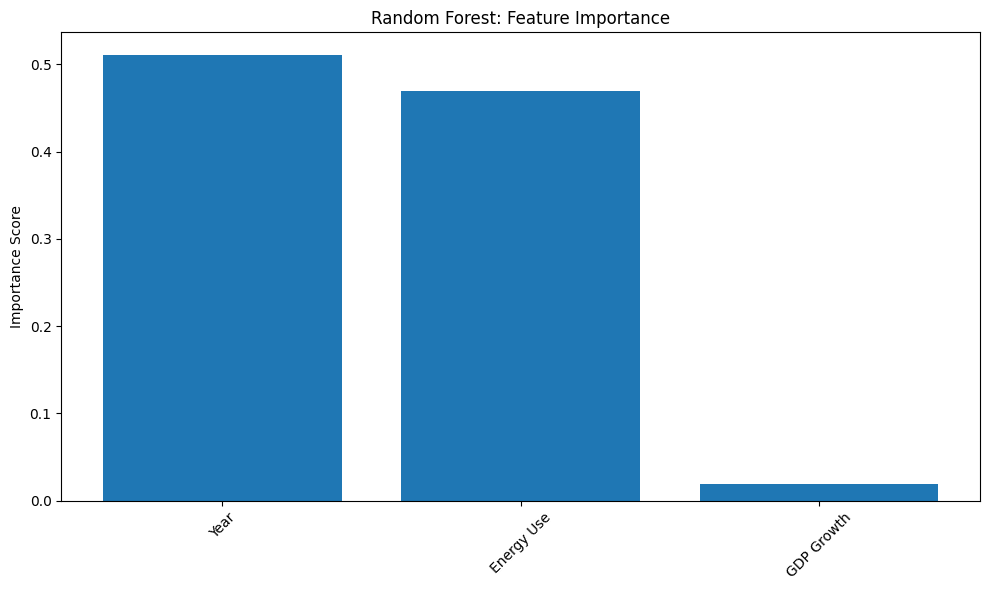

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

print("## Random Forest Regression: Multi-Feature Prediction")

if not norway_merged.empty:
    X_rf = norway_merged[['Energy_use_per_capita', 'GDP_growth', 'Year']].values
    y_rf = norway_merged['CO2_per_capita'].values
    
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
    rf_model.fit(X_train_rf, y_train_rf)
    
    y_pred_rf_train = rf_model.predict(X_train_rf)
    y_pred_rf_test = rf_model.predict(X_test_rf)
    
    print(f"Random Forest Performance:")
    print(f"Training R²: {r2_score(y_train_rf, y_pred_rf_train):.3f}")
    print(f"Test R²: {r2_score(y_test_rf, y_pred_rf_test):.3f}")
    print(f"Training MAE: {mean_absolute_error(y_train_rf, y_pred_rf_train):.3f}")
    print(f"Test MAE: {mean_absolute_error(y_test_rf, y_pred_rf_test):.3f}")
    
    feature_importance = pd.DataFrame({
        'Feature': ['Energy Use', 'GDP Growth', 'Year'],
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nFeature Importance:")
    print(feature_importance.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['Feature'], feature_importance['Importance'])
    plt.title('Random Forest: Feature Importance')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV Score: 0.844
Random Forest model saved as 'random_forest_model.pkl'

Performance:
Training R²: 0.987
Test R²: 0.953
Training MAE: 0.145
Test MAE: 0.363
Training RMSE: 0.200
Test RMSE: 0.412

Feature Importance:
   Feature  Importance
      Year    0.566950
Energy Use    0.413487
GDP Growth    0.019563

CV R² Scores: [0.95027654 0.69840424 0.87669736 0.75032819 0.94222901]
Mean CV R²: 0.844 (+/- 0.204)

Future Predictions (Random Forest):
2025: 8.86 metric tons per capita
2030: 8.86 metric tons per capita
2035: 8.86 metric tons per capita
2040: 8.86 metric tons per capita
2045: 8.86 metric tons per capita


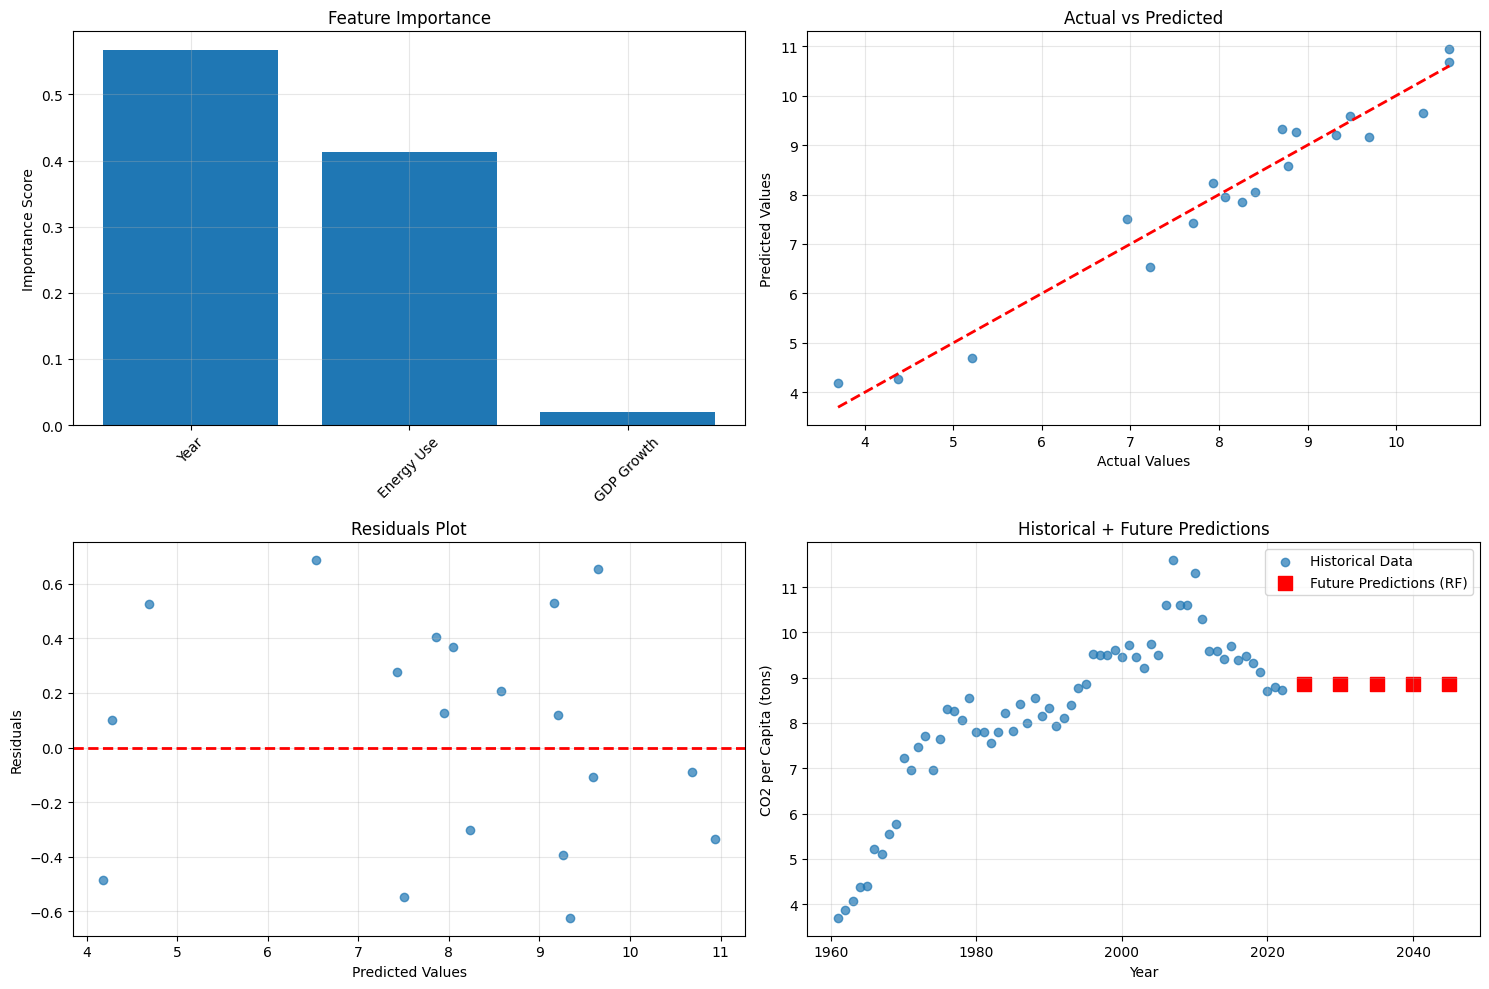

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
import joblib

if not norway_merged.empty:
    X_rf = norway_merged[['Energy_use_per_capita', 'GDP_growth', 'Year']].values
    y_rf = norway_merged['CO2_per_capita'].values
    
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf_base = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf_base, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=0)
    grid_search.fit(X_train_rf, y_train_rf)
    
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best CV Score: {grid_search.best_score_:.3f}")
    
    rf_model = grid_search.best_estimator_
    rf_model.fit(X_train_rf, y_train_rf)
    
    # Save the model
    joblib.dump(rf_model, 'random_forest_model.pkl')
    print("Random Forest model saved as 'random_forest_model.pkl'")
    
    y_pred_rf_train = rf_model.predict(X_train_rf)
    y_pred_rf_test = rf_model.predict(X_test_rf)
    
    print(f"\nPerformance:")
    print(f"Training R²: {r2_score(y_train_rf, y_pred_rf_train):.3f}")
    print(f"Test R²: {r2_score(y_test_rf, y_pred_rf_test):.3f}")
    print(f"Training MAE: {mean_absolute_error(y_train_rf, y_pred_rf_train):.3f}")
    print(f"Test MAE: {mean_absolute_error(y_test_rf, y_pred_rf_test):.3f}")
    print(f"Training RMSE: {np.sqrt(mean_squared_error(y_train_rf, y_pred_rf_train)):.3f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_rf, y_pred_rf_test)):.3f}")
    
    feature_importance = pd.DataFrame({
        'Feature': ['Energy Use', 'GDP Growth', 'Year'],
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nFeature Importance:")
    print(feature_importance.to_string(index=False))
    
    cv_scores = cross_val_score(rf_model, X_train_rf, y_train_rf, cv=5, scoring='r2')
    print(f"\nCV R² Scores: {cv_scores}")
    print(f"Mean CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    # Future predictions
    future_years = np.array([2025, 2030, 2035, 2040, 2045])
    
    # For future predictions, we need to estimate energy and GDP values
    # Using simple extrapolation based on recent trends
    recent_energy = norway_merged['Energy_use_per_capita'].iloc[-5:].mean()
    recent_gdp = norway_merged['GDP_growth'].iloc[-5:].mean()
    
    future_features = []
    for year in future_years:
        future_features.append([recent_energy, recent_gdp, year])
    
    future_features = np.array(future_features)
    future_predictions_rf = rf_model.predict(future_features)
    
    print(f"\nFuture Predictions (Random Forest):")
    for year, pred in zip(future_years, future_predictions_rf):
        print(f"{year}: {pred:.2f} metric tons per capita")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].bar(feature_importance['Feature'], feature_importance['Importance'])
    axes[0, 0].set_title('Feature Importance')
    axes[0, 0].set_ylabel('Importance Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].scatter(y_test_rf, y_pred_rf_test, alpha=0.7)
    axes[0, 1].plot([y_test_rf.min(), y_test_rf.max()], [y_test_rf.min(), y_test_rf.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].set_title('Actual vs Predicted')
    axes[0, 1].grid(True, alpha=0.3)
    
    residuals = y_test_rf - y_pred_rf_test
    axes[1, 0].scatter(y_pred_rf_test, residuals, alpha=0.7)
    axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Predicted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals Plot')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Historical + Future predictions plot
    axes[1, 1].scatter(norway_merged['Year'], norway_merged['CO2_per_capita'], alpha=0.7, label='Historical Data')
    axes[1, 1].scatter(future_years, future_predictions_rf, color='red', s=100, marker='s', label='Future Predictions (RF)')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('CO2 per Capita (tons)')
    axes[1, 1].set_title('Historical + Future Predictions')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# CNN

CNN Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1, 32)          │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1, 8)           │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,979 (31.17 KB)

 Trainable params: 7,979 (31.17 KB)

 Non-trainable params: 0 (0.00 B)

Training CNN...


CNN model saved as 'cnn_model.h5'
CNN scaler saved as 'cnn_scaler.pkl'
Training R²: 0.957
Test R²: 0.954
Training MAE: 0.457
Test MAE: 0.504
Epochs trained: 72

Future Predictions (CNN):
2025: 11.24 metric tons per capita
2030: 11.73 metric tons per capita
2035: 12.23 metric tons per capita
2040: 12.72 metric tons per capita
2045: 13.22 metric tons per capita


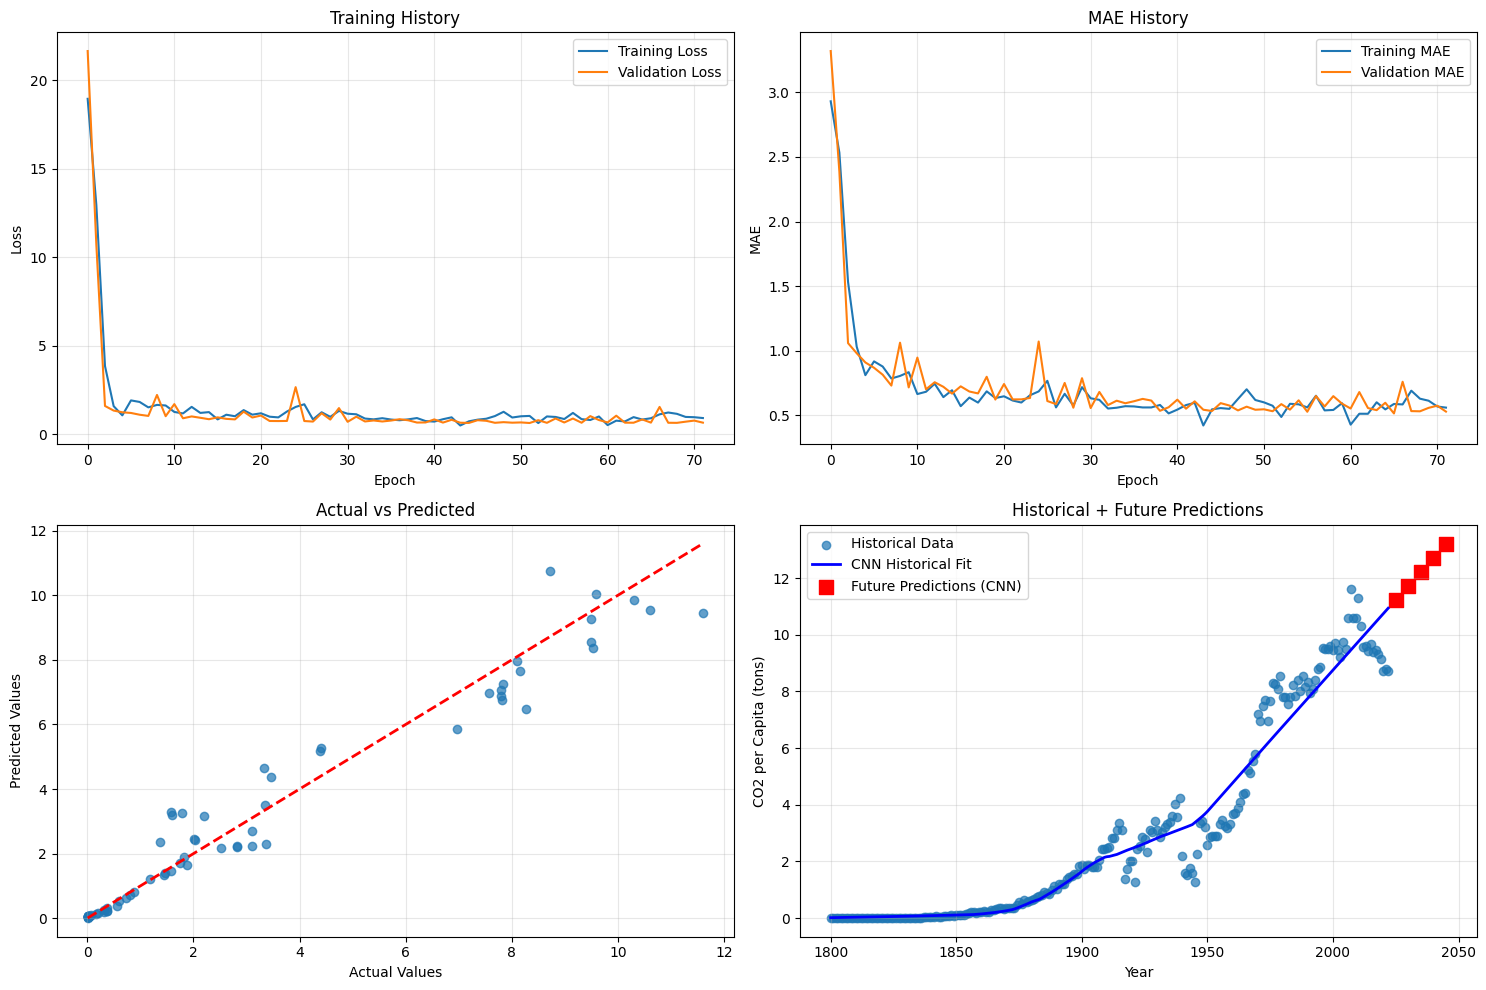

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

if len(norway_yearly) > 20:
    X_cnn = norway_yearly['Year'].values.reshape(-1, 1)
    y_cnn = norway_yearly['CO2_per_capita'].values
    
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.3, random_state=42)
    
    scaler_cnn = StandardScaler()
    X_train_cnn_scaled = scaler_cnn.fit_transform(X_train_cnn)
    X_test_cnn_scaled = scaler_cnn.transform(X_test_cnn)
    
    X_train_cnn_reshaped = X_train_cnn_scaled.reshape(X_train_cnn_scaled.shape[0], X_train_cnn_scaled.shape[1], 1)
    X_test_cnn_reshaped = X_test_cnn_scaled.reshape(X_test_cnn_scaled.shape[0], X_test_cnn_scaled.shape[1], 1)
    
    model_cnn = Sequential([
        Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(1, 1)),
        Conv1D(filters=16, kernel_size=1, activation='relu'),
        Conv1D(filters=8, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    print("CNN Model Summary:")
    model_cnn.summary()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    print("Training CNN...")
    history = model_cnn.fit(
        X_train_cnn_reshaped, y_train_cnn,
        epochs=200, batch_size=8, validation_split=0.2, 
        callbacks=[early_stopping], verbose=0
    )
    
    # Save the model
    model_cnn.save('cnn_model.h5')
    print("CNN model saved as 'cnn_model.h5'")
    
    # Save the scaler
    joblib.dump(scaler_cnn, 'cnn_scaler.pkl')
    print("CNN scaler saved as 'cnn_scaler.pkl'")
    
    y_pred_cnn_train = model_cnn.predict(X_train_cnn_reshaped, verbose=0).flatten()
    y_pred_cnn_test = model_cnn.predict(X_test_cnn_reshaped, verbose=0).flatten()
    
    print(f"Training R²: {r2_score(y_train_cnn, y_pred_cnn_train):.3f}")
    print(f"Test R²: {r2_score(y_test_cnn, y_pred_cnn_test):.3f}")
    print(f"Training MAE: {mean_absolute_error(y_train_cnn, y_pred_cnn_train):.3f}")
    print(f"Test MAE: {mean_absolute_error(y_test_cnn, y_pred_cnn_test):.3f}")
    print(f"Epochs trained: {len(history.history['loss'])}")
    
    # Future predictions
    future_years = np.array([2025, 2030, 2035, 2040, 2045])
    future_years_scaled = scaler_cnn.transform(future_years.reshape(-1, 1))
    future_years_reshaped = future_years_scaled.reshape(future_years_scaled.shape[0], future_years_scaled.shape[1], 1)
    future_predictions_cnn = model_cnn.predict(future_years_reshaped, verbose=0).flatten()
    
    print(f"\nFuture Predictions (CNN):")
    for year, pred in zip(future_years, future_predictions_cnn):
        print(f"{year}: {pred:.2f} metric tons per capita")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Training History')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history.history['mae'], label='Training MAE')
    axes[0, 1].plot(history.history['val_mae'], label='Validation MAE')
    axes[0, 1].set_title('MAE History')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].scatter(y_test_cnn, y_pred_cnn_test, alpha=0.7)
    axes[1, 0].plot([y_test_cnn.min(), y_test_cnn.max()], [y_test_cnn.min(), y_test_cnn.max()], 'r--', lw=2)
    axes[1, 0].set_xlabel('Actual Values')
    axes[1, 0].set_ylabel('Predicted Values')
    axes[1, 0].set_title('Actual vs Predicted')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Historical + Future predictions plot
    X_all_scaled = scaler_cnn.transform(norway_yearly['Year'].values.reshape(-1, 1))
    X_all_reshaped = X_all_scaled.reshape(X_all_scaled.shape[0], X_all_scaled.shape[1], 1)
    y_all_pred = model_cnn.predict(X_all_reshaped, verbose=0).flatten()
    
    axes[1, 1].scatter(norway_yearly['Year'], norway_yearly['CO2_per_capita'], alpha=0.7, label='Historical Data')
    axes[1, 1].plot(norway_yearly['Year'], y_all_pred, color='blue', linewidth=2, label='CNN Historical Fit')
    axes[1, 1].scatter(future_years, future_predictions_cnn, color='red', s=100, marker='s', label='Future Predictions (CNN)')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('CO2 per Capita (tons)')
    axes[1, 1].set_title('Historical + Future Predictions')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()